In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display, clear_output
import tensorflow as tf # gives warning from h5py but it is fine.
%matplotlib inline

C:\Users\spenc\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
tf.__version__

'1.6.0'

In [4]:
from IPython.display import display, clear_output as clc
import sys

In [5]:
d0 = pd.read_csv ('train_final.csv', index_col=0)
d0.head ()

,Y,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27
id,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0.107576,0,0.0,1,1,1,1,...,104,22902.0,1,0,18,0.042295,1,0,27,0.028250
2,0,1,0,0.142357,0,0.0,7,1,1,1,...,144,11400.0,1,0,8,0.021417,1,0,67,0.253574
3,0,1,0,0.492318,0,3.0,4205,1,1,3,...,112,4833.0,1,0,13,0.502212,1,1,35,0.373397
4,0,1,0,-0.053028,0,2.0,2,1,1,5,...,127,3250.0,1,1,8,0.000000,1,0,50,0.674254
5,0,1,0,0.730797,0,0.0,11,1,1,1,...,148,4000.0,1,1,5,0.787592,1,0,71,0.371157


In [6]:
import pandas as pd
from IPython.display import display

def stats(data, others=dict()):
    if not isinstance(data, pd.DataFrame):
        data = data.to_frame()
    stats = pd.concat([data.nunique(), data.dtypes, data.isnull().sum()], axis=1)
    stats.columns = ['Unique', 'Dtypes', 'NaN Count']
    for k,v in others.items():
        stats[k] = v(data)
    return stats

def page(data, wrap_cols=14):
    if not isinstance(data, pd.DataFrame):
        data = data.to_frame().T
    for i in range(wrap_cols, data.shape[1]+wrap_cols, wrap_cols):
        print ('Columns', i-wrap_cols, '-', min(i-1,data.shape[1]-1))
        display(data.iloc[:, i-wrap_cols:i])

In [7]:
page (d0.nunique ().T)
# page (d0.dtypes)
page (d0.isnull ().sum ())

Columns 0 - 13


,Y,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13
0,2,9,12,49998,9,11,1880,9,9,322,23,43,9,10


Columns 14 - 27


,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27
0,16,10,310,9,83,8770,10,334,55,42562,9,14,83,41705


Columns 0 - 13


,Y,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13
0,0,0,0,0,0,1268,0,0,0,0,0,0,0,0


Columns 14 - 27


,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27
0,0,0,0,0,0,9828,0,0,0,0,0,0,0,0


In [8]:
d1 = d0.fillna (method='ffill')
page (d1.isnull ().sum ())

Columns 0 - 13


,Y,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Columns 14 - 27


,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
page (d0.iloc[:,5].value_counts ())
page (d1.iloc[:,5].value_counts ())

Columns 0 - 10


,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
F5,29110,8682,6516,3129,977,232,55,18,8,2,1


Columns 0 - 10


,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
F5,29863,8904,6701,3202,1002,242,55,18,8,2,1


In [10]:
# split based on number of unique values (even though some continuous features have int64 type)
continuous_cols = set ([3, 6, 9, 16, 19, 21, 23, 27])
categorical_cols = set (range (1, 28)) - continuous_cols
continuous_cols, categorical_cols

({3, 6, 9, 16, 19, 21, 23, 27},
 {1, 2, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 17, 18, 20, 22, 24, 25, 26})

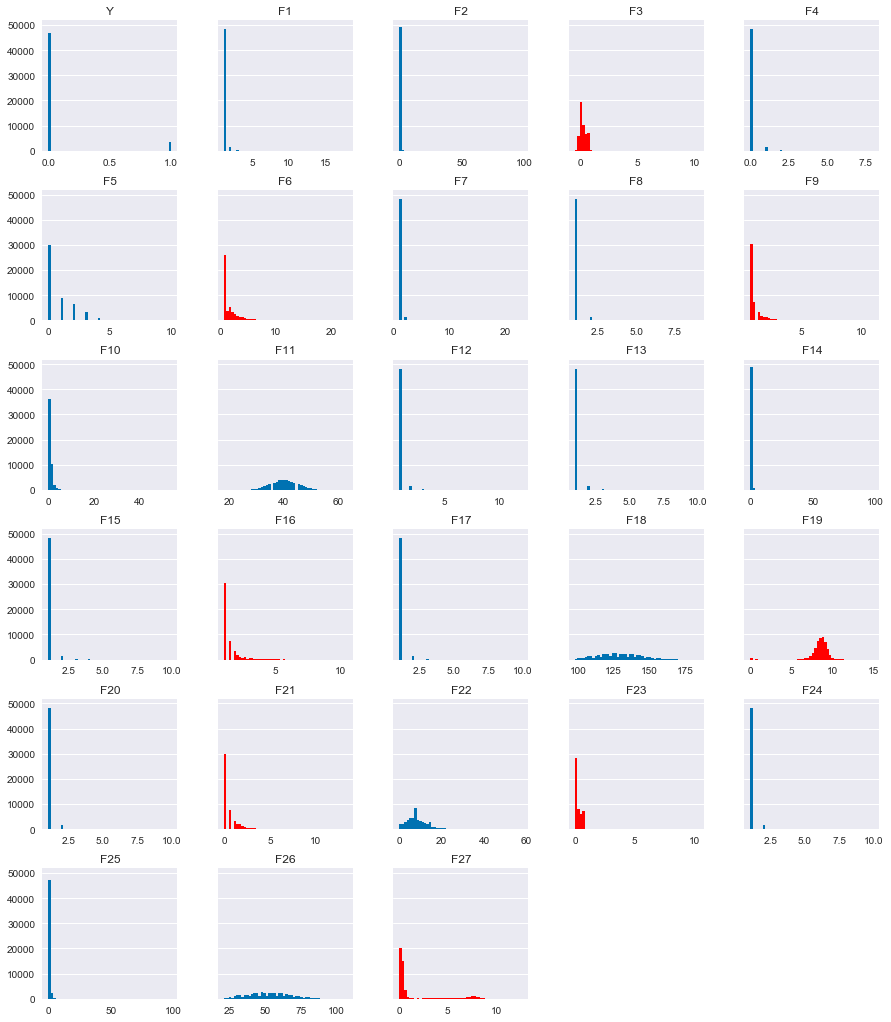

In [11]:
import math
cols = 5
rows = math.ceil (d1.shape[1]/cols)
fig, ax = plt.subplots (rows, cols, figsize=(3*cols,3*rows), sharey=True)
plt.subplots_adjust (hspace=.3, wspace=.3)
for i, (a, col) in enumerate (zip (ax.flat, d1)):
    plt.sca (a)
    if d1[col].nunique () > 100:
        plt.hist (np.log1p (d1[col]), bins=50, color='r')
    else:
        plt.hist (d1[col], bins=50)
    plt.grid (axis='x')
    plt.title (col)

for a in ax.flat[d1.shape[1]:]:
    plt.delaxes (a)

In [ ]:
from tf import feature_column
from tf.estimator import Estimator, ModeKeys
import math

class FLAGS:
    width = 128
    batch_size = width * 128

tf.estimator.inputs.pandas_input_fn(
    d1.iloc[:,1:],
    y=d1['Y'],
    batch_size=FLAGS.batch_size,
    num_epochs=1,
    shuffle=True,
    queue_capacity=10*FLAGS.batch_size,
    num_threads=1,
    target_column='Y'
)

def model_fn (features, label, mode):
    
    categorical = []
    
    # embed categorical features
    for col_idx in categorical_cols:
        name = d1.columns[col_idx]
        num_unique = d1.iloc[:,col_idx].nunique ()
        column = categorical_column_with_identity (
            key=name,
            num_buckets=num_unique
        )
        embedded = embedding_column (column, math.lg (num_unique))
        categorical.append (embedded)
    
    # group together continuous features
    continuous = [numeric_column (d1.columns[col_idx]) for col_idx in continuous_cols]
    
    # x1: form first layer of all features
    inputs = input_layer (features, categorical + continuous)
    
    # build convolutional layers
    
    # y1, var_y1: replicate each sample in a batch FLAGS.width times and evaluate.
    # then get mean (y1) and variance (var_y1).
    
    # x2: sort all samples in batch by their individual evaluation mean (y1)
    
    # y2: evaluate sorted samples (x2)
    
    # if mode is PREDICT return with predictions=y2
    # (handle coalescing all predictions for a given sample outside)
    
    # loss: mean var_y1 of all samples + cross-entropy of y2 vs. labels
    
    # optimize loss
    
    # if TRAIN, done.
    
    # log var_y1, (loss - var_y1) = cross entropy
    
    # mode is EVAL, done.
    